<a href="https://colab.research.google.com/github/lonespear/pubscrabe/blob/main/review_replicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install deprecated versions of numpy and spacy for package dependencies
!pip install numpy==1.26.4 > out
!pip install spacy==3.7.2 > out

#Package Bio scrapes pubmed.gov
!pip install biopython > out

# sumy required for abstract summarization
!pip install sumy > out

# for group names and summaries
!pip install transformers > out
!pip install tf-keras --user > out
!pip install bertopic > out

!pip install spacy > out
!python -m spacy download en_core_web_lg > out

!pip install selenium > out
!pip install bs4 > out

In [2]:
# to scrape pubmed
from Bio import Entrez
import pandas as pd
from collections import Counter

# for the abstract summarization
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from nltk.tokenize import word_tokenize

# for plotting purposes and K-means
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# used for creating descriptions of they key word cluster
from transformers import pipeline

# For preprocessing and lemmitization of Abstracts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize
import nltk

# For LDA grouping
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

# Download the required NLTK resources
nltk.download('punkt_tab')
nltk.download('wordnet')

import spacy
spacy.load('en_core_web_lg')


# for BERTtopic
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sentence_transformers import models

Entrez.email = "jonathan.day@westpoint.edu"

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Scraping Functions

In [3]:
def search_pubmed(query, max_results=20000, start_date=None, review_papers_only = False):
    """
    Perform a search on PubMed using the given query and return the results, with a fixed end date and a variable start date.

    :param query: The search query string.
    :param max_results: The maximum number of results to retrieve.
    :param start_date: The earliest publication date to include (YYYY/MM/DD format), default is None.
    :param review_papers_only: Boolean value that picks if the query will only scrape for review papers default is False
    :return: The search results in XML format.
    """
    # Set the fixed end date
    end_date = "2024/09/10" # for reproducibilty, we use a fixed end date, but in pracitce, this should be today's date

    # If a start_date is provided, modify the query to include the date range
    if start_date:
        query += f" AND ({start_date}[Date - Publication] : {end_date}[Date - Publication])"
    else:
        query += f" AND ( 0000/01/01[Date - Publication] : {end_date}[Date - Publication])"

    # Modify query to only pick up review papers
    if review_papers_only:
        query += f" AND (review[pt])"

    # Use the esearch utility to search PubMed
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_results, usehistory='y')
    # Read the search results
    record = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()

    # Print the total number of articles found on PubMed for this query
    total_articles = int(record["Count"])
    print(f"Query: {query}")
    print(f"Total articles found for the query: {total_articles}")

    # Extract the list of PubMed IDs (PMIDs) from the search results
    id_list = record["IdList"]

    # Use the efetch utility to fetch details for each PMID
    handle = Entrez.efetch(db="pubmed", id=id_list, retmode="xml")
    # Read the fetched records
    records = Entrez.read(handle)
    # Close the handle to free up resources
    handle.close()

    return records

def summarize_abstract(abstract):
    """
    Summarize the abstract into 1-2 sentences using LSA summarization.

    :param abstract: The abstract of the article.
    :return: A summary of the abstract.
    """
    if not abstract:
        return ""

    # Use the CustomTokenizer
    parser = PlaintextParser.from_string(abstract, Tokenizer('english'))
    summarizer = LsaSummarizer()
    summary = summarizer(parser.document, 2)  # Summarize to 2 sentences

    return " ".join(str(sentence) for sentence in summary)

def extract_article_info(records):
    """
    Extract core article information from PubMed records, including title, authors, abstract, PubMed ID, URL, references, publication date, and journal.

    :param records: The PubMed records in XML format.
    :return: A DataFrame containing the extracted information.
    """
    data = []

    for article in records["PubmedArticle"]:
        # Extract authors and concatenate their names, if available
        authors_list = []
        if "AuthorList" in article["MedlineCitation"]["Article"]:
            for author in article["MedlineCitation"]["Article"]["AuthorList"]:
                last_name = author.get("LastName", "")
                fore_name = author.get("ForeName", "")
                authors_list.append(last_name + " " + fore_name)
            authors = ", ".join(authors_list)
        else:
            authors = ""

        # Extract the article title
        title = article["MedlineCitation"]["Article"]["ArticleTitle"]

        # Extract the article abstract (or use an empty string if not available)
        abstract = article["MedlineCitation"]["Article"].get("Abstract", {}).get("AbstractText", [""])[0]

        # Extract the PubMed ID
        pubmed_id = article["MedlineCitation"]["PMID"]

        # Construct the PubMed URL
        url = f"https://pubmed.ncbi.nlm.nih.gov/{pubmed_id}/"

        # Extract the journal name
        journal = article["MedlineCitation"]["Article"].get("Journal", {})
        journal_name = journal.get("Title", "")

        # Extract publication date
        pub_date = ""

        if "PubDate" in journal:
            pub_date_obj = journal["PubDate"]
            year = pub_date_obj.get("Year", "")
            month = pub_date_obj.get("Month", "")
            day = pub_date_obj.get("Day", "")
            pub_date = f"{year}-{month}-{day}".strip("-")
        elif "MedlineDate" in journal.get("PubDate", {}):
            pub_date = journal["PubDate"]["MedlineDate"]

        # Summarize the abstract
        summary = summarize_abstract(abstract)

        # Append the extracted data
        data.append({
            "Authors": authors,
            "Title": title,
            "Abstract": abstract,
            "Summary": summary,
            "PublicationDate": pub_date,
            "PubMedURL": url,
            "Journal": journal_name
        })

    # Convert the list of dictionaries to a DataFrame for easier handling
    return pd.DataFrame(data)

def classify_articles(article_df):
    """
    Perform keyword-based classification on the articles and flag studies based on specific criteria.
    This classification is a simple key-word search.

    :param article_df: DataFrame containing article information (title, abstract, summary, etc.).
    :return: Updated DataFrame with classification flags, a new column for each desired category with a 1 if it fits the category and a 0 if it does not.
    """
    longitudinal_terms = ["longitudinal", "long-term follow up", "long term follow up", "follow-up", "follow up"]
    systematic_review_terms = [
        "systematic review", "systematic overview", "systematic literature review",
        "systematic analysis", "review of reviews", "evidence synthesis",
        "review protocol", "systematically reviewed", "literature synthesis",
        "PRISMA"
    ]
    meta_analysis_terms = [
        "meta-analysis", "meta analysis", "meta-analyses",
        "meta analytic", "meta-regression", "meta regression",
        "pooled effect", "statistical synthesis",
        "heterogeneity", "fixed-effects model", "random-effects model"
    ]
    human_study_terms = [" human ", " patient", "participants", ' twin ']
    animal_study_terms = [" rat ", " mouse ", " mice ", " animal ", " rodent ", "zebrafish", "drosophila", "rabbit", " dog ", " cat ", " monkey ", "non-human primate"]

    # Combine Title and Abstract for Keyword Search
    article_df['Title_Abstract'] = article_df['Title'] + " " + article_df['Abstract']

    # Apply keyword searching and flagging on the combined 'Title_Abstract'
    article_df['LongitudinalStudy'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in longitudinal_terms) else 0)
    article_df['SystematicReview'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in systematic_review_terms) else 0)
    article_df['MetaAnalysis'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in meta_analysis_terms) else 0)
    article_df['HumanStudy'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in human_study_terms) else 0)
    article_df['AnimalStudy'] = article_df['Title_Abstract'].apply(lambda x: 1 if any(term in x.lower() for term in animal_study_terms) else 0)

    # Drop the 'Title_Abstract' helper column
    article_df.drop(columns=['Title_Abstract'], inplace=True)

    return article_df

    #This code chunk saves the scraped data to a csv.
def save_to_csv(data, filename):
    """
    Save the extracted data to a CSV file.

    :param data: The list of dictionaries containing the extracted information.
    :param filename: The name of the CSV file to save the data to.
    """
    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)

# Preprocessing

def tokenize_and_lemmatize(df):
    """
    Processes a DataFrame by lemmatizing and tokenizing the 'Preprocessed_Abstract' column and
    returns the DataFrame with an updated column containing the processed text.

    :param df: DataFrame with a 'Preprocessed_Abstract' column.
    :return: DataFrame with a modified 'Preprocessed_Abstract' column containing lemmatized text.
    """
    # Initialize the WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    # Get the default English stopwords from spacy
    nlp = spacy.load('en_core_web_lg')
    stop_words = nlp.Defaults.stop_words

    # Function to preprocess, tokenize, and lemmatize text
    def preprocess(text):
        tokens = text.split()
        return ' '.join([lemmatizer.lemmatize(word.lower()) for word in tokens if word.lower() not in stop_words])

    # Apply the preprocessing and tokenization function
    df['Preprocessed_Abstract'] = df['Abstract'].fillna('').apply(lambda text: preprocess(text))

    # Remove custom stopwords using regular expressions
    df['Preprocessed_Abstract'] = df['Preprocessed_Abstract'].replace(r'\bsup\b|\bsub\b|\bsp\b|\bwa\b', '', regex=True)
    df['Preprocessed_Abstract'] = df['Preprocessed_Abstract'].replace(r'\balso\b|\bhowever\b|\bmay\b|\busing\b', '', regex=True)

    return df

# K-means method

def cluster_and_filter_relevance(df, n_clusters=5, n_key_words=10):
    """
    Perform K-means clustering on the articles' abstracts and filter the most relevant clusters with lemmatization.
    USes TF-IDF to vectorize the documents and K-means to cluster them into groups

    :param df: DataFrame containing the articles data.
    :param n_clusters: Number of clusters to create.
    :param n_key_words: Number of top keywords to use for filtering relevant clusters.

    :return: Filtered DataFrame with relevant clusters, and a dictionary containing cluster keywords.
    """
    # Vectorize the text data
    # max_df: if a word is contianed in 95% of documents it is discarded
    # min_df: if a word is only contained in 2 or less documents it is discarded
    vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words='english')
    X = vectorizer.fit_transform(df['Preprocessed_Abstract'].fillna(''))

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    df['Cluster'] = kmeans.labels_

    # Analyze the clusters to determine relevance
    # Initialize a dictionary to store the keywords for each cluster
    cluster_keywords = {}
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    # Iterate through each cluster and store the top n keywords
    for i in range(n_clusters):
        cluster_keywords[i] = [terms[ind] for ind in order_centroids[i, :n_key_words]]

    # Here you could filter clusters based on relevance, or simply drop the combined column
    df_filtered = df.copy()  # If you want to perform further filtering, modify df_filtered

    # Return both the filtered DataFrame and the cluster_keywords dictionary
    return df_filtered, cluster_keywords

def bert_topic_analysis(df):
    """
    Performs BERTopic analysis on the 'Preprocessed_Abstract' column using a medical language model for embeddings.

    :param df: DataFrame with a 'Preprocessed_Abstract' column.
    :return: BERTopic model and topics.
    """
    # Ensure text data is lemmatized and preprocessed
    docs = df['Preprocessed_Abstract'].tolist()

    # Load the Bio_ClinicalBERT model and wrap it for sentence-transformers compatibility
    model_name = "emilyalsentzer/Bio_ClinicalBERT"
    word_embedding_model = models.Transformer(model_name)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode='mean')
    embedding_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    # Initialize BERTopic with the medical embedding model
    topic_model = BERTopic(embedding_model=embedding_model)

    # Fit the model and transform the documents into topics
    topics, probs = topic_model.fit_transform(docs)

    # Show the extracted topics
    print(topic_model.get_topic_info())

    # Visualize topics
    topic_model.visualize_topics()

    # Add Clusters to df
    df['BERT Cluster'] = topics

    return topic_model, topics, probs

# LDA

def lda_topic_analysis(df, num_topics=5, num_top_words=10):
    """
    Performs LDA topic analysis on the 'Title' and 'Abstract' columns of the given DataFrame,
    reduces dimensionality using t-SNE, and visualizes the topics in 2D space.

    :param df: DataFrame with 'Title' and 'Abstract' columns.
    :param num_topics: The number of topics to extract (default is 5).
    :param num_top_words: The number of top words to display for each topic (default is 10).
    :return: LDA model, document topic distribution, and t-SNE transformed data.
    """
    # Combine the text from the 'Title' and 'Abstract' columns
    text_data = df['Preprocessed_Abstract']

    # Use CountVectorizer to convert the text data into a matrix of token counts
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(text_data)

    # Define the LDA model with the number of topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    # Get the topic distribution for each document
    doc_topic_dist = lda.transform(X)

    # Reduce the dimensionality of the topics for visualization using t-SNE
    tsne_model = TSNE(n_components=2, random_state=42)
    tsne_lda = tsne_model.fit_transform(doc_topic_dist)

    # Plot the topics in a 2D space
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=doc_topic_dist.argmax(axis=1), cmap='viridis')
    plt.colorbar(label='Topic')
    plt.title('2D Visualization of LDA Topics')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

    # Display the top words in each topic
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

    df['LDA Cluster'] = doc_topic_dist.argmax(axis=1)

    return df, lda, doc_topic_dist, tsne_lda

# Combine abstracts from a specific cluster
def combine_abstracts(dataframe, cluster_label):
    """
    Combine abstracts of a specific cluster into a single text.

    :param dataframe: DataFrame containing article abstracts and cluster labels.
    :param cluster_label: The label of the cluster to combine abstracts for.
    :return: Combined text of abstracts.
    """
    # Filter the DataFrame to the specific cluster and get the 'Abstract' column
    abstracts = dataframe[dataframe['Cluster'] == cluster_label]['Preprocessed_Abstract']

    # Combine abstracts into a single text string
    combined_text = " ".join(abstracts.dropna().tolist())

    return combined_text

# Summarize the combined abstracts
def summarize_text(text, model_name = False, max_length=300, min_length=100):
    """
    Summarize the combined abstracts text.

    :param text: The combined text of abstracts.
    :param model_name: Model to use for summarization (default: BART Bio_ClinicalBERT).
    :param max_length: Maximum length of the summary.
    :param min_length: Minimum length of the summary.
    :return: Summary of the text.
    """
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

    if model_name:
        # Initialize the summarization pipeline
        summarizer = pipeline("summarization", model=model_name)
    else:
        tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")
        summarizer = pipeline("summarization", model="google/pegasus-xsum", tokenizer=tokenizer)

        #tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        #model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        #summarizer = pipeline("summarization", model=model)

    # Summarize the text
    summary = summarizer(text, max_length=max_length, min_length=min_length, truncation=True)[0]['summary_text']

    return summary

def summarize_nltk(text, max_chars=500):
    """
    Summarize text using nltk by selecting sentences up to a character limit.

    :param text: Text to summarize.
    :param max_chars: Maximum character length for the summary.
    :return: Summary of the text within max_chars.
    """
    sentences = sent_tokenize(text)
    summary = ""

    for sentence in sentences:
        if len(summary) + len(sentence) <= max_chars:
            summary += sentence + " "
        else:
            break

    return summary.strip()


Atypical ductal or lobular hyperplasia, lobular carcinoma in-situ, flat
epithelial atypia, and future risk of developing breast cancer: Systematic
review and meta-analysis

In [7]:
query = ("""
    (atypi* OR benign* OR abnormal*)[Title/Abstract]
    AND (hyperplas* OR proliferat* OR disease* OR histolog* OR diagnos* or lesion*)[Title/Abstract]
    AND ((lobular carcinoma in situ OR lobular neoplas* OR flat epithelial atypi* OR lobular intra$epithelial neoplas* OR lobular intra epithelial neoplas*)[Title/Abstract]
    OR ((atypi* or benign* or abnormal*) adj2 (hyperplas* or proliferat* or disease* or histolog* or dianos* or cytolog* or lesion*))[Title/Abstract])
    AND (risk* or progress* or diagnos* or develop* or rate* or potential* or associat* or incidence* or subsequent*)[Title/Abstract]
    AND (cancer* or carcinoma* or malignan* or neoplas*)[Title/Abstract]
    AND (breast* or mamm*)[Title/Abstract]
    AND ((ductal carcinoma in situ)[Title/Abstract]
    OR ((cancer* or carcinoma* or malignan* or neoplas*) adj3 (breast* or mamm*)))
    AND (English[Language] AND Humans[MeSH Terms])
    AND ("2000"[Date - Publication] : "2023"[Date - Publication])
    """)

query = (
    "((atypia OR benign OR abnormal OR hyperplasia OR proliferative OR histology OR diagnosis OR lesion)[Title/Abstract]) "
    "AND (\"lobular carcinoma in situ\" OR \"lobular neoplasia\" OR \"flat epithelial atypia\" OR \"ductal carcinoma in situ\" "
    "OR \"intraepithelial neoplasia\" OR \"breast lesion\" OR \"atypical hyperplasia\")[Title/Abstract] "
    "AND (cancer OR carcinoma OR malignant OR neoplasia OR tumor OR tumour)[Title/Abstract] "
    "AND (breast OR mammary)[Title/Abstract] "
    "AND (English[Language] AND Humans[MeSH Terms]) "
    "AND (\"2000\"[Date - Publication] : \"2023\"[Date - Publication])"
)

max_results = 100000  # Adjust the number of results to retrieve as needed
n_key_words = 10     # Adjust number of key words you want
n_clusters = 5       # Adjust number of clusters you want for the k-means clustering algorithm

In [8]:
# Perform the search and retrieve the records
records = search_pubmed(query, max_results)

Query: ((atypia OR benign OR abnormal OR hyperplasia OR proliferative OR histology OR diagnosis OR lesion)[Title/Abstract]) AND ("lobular carcinoma in situ" OR "lobular neoplasia" OR "flat epithelial atypia" OR "ductal carcinoma in situ" OR "intraepithelial neoplasia" OR "breast lesion" OR "atypical hyperplasia")[Title/Abstract] AND (cancer OR carcinoma OR malignant OR neoplasia OR tumor OR tumour)[Title/Abstract] AND (breast OR mammary)[Title/Abstract] AND (English[Language] AND Humans[MeSH Terms]) AND ("2000"[Date - Publication] : "2023"[Date - Publication]) AND ( 0000/01/01[Date - Publication] : 2024/09/10[Date - Publication])
Total articles found for the query: 7659


In [9]:
# Parse the retrieved records to extract the desired information
articles_data = pd.DataFrame(extract_article_info(records))

In [ ]:
articles_data.head()

,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal
0,"Miceli Rachel, Mercado Cecilia L, Hernandez Os...",Active Surveillance for Atypical Ductal Hyperp...,Atypical ductal hyperplasia (ADH) and ductal c...,"Furthermore, some DCIS lesions do not progress...",,https://pubmed.ncbi.nlm.nih.gov/38416903/,Journal of breast imaging
1,"DiPrete Olivia, Wei Catherine J, Phillips Jord...",Management of Mammographic Architectural Disto...,The objective was to evaluate outcomes of mamm...,The objective was to evaluate outcomes of mamm...,,https://pubmed.ncbi.nlm.nih.gov/38416901/,Journal of breast imaging
2,"Wang Xiaoxia, Du Lihong, Cao Ying, Chen Huifan...",Comparing extracellular volume fraction with a...,To investigate the feasibility of dual-energy ...,To investigate the feasibility of dual-energy ...,,https://pubmed.ncbi.nlm.nih.gov/38159522/,European journal of radiology
3,"Zhang Li-Xia, Zhang Li, Jiang Li-Li, Mi Hui, L...",Perioperative care of nipple-areola complex-sp...,Breast cancer represents a prevalent malignanc...,Breast cancer represents a prevalent malignanc...,,https://pubmed.ncbi.nlm.nih.gov/38115362/,Medicine
4,"Rubio Isabel T, Wyld Lynda, Marotti Lorenza, A...","European guidelines for the diagnosis, treatme...",Breast lesions of uncertain malignant potentia...,They are challenging to categorise histologica...,,https://pubmed.ncbi.nlm.nih.gov/38061151/,European journal of surgical oncology : the jo...


In [ ]:
# Create your function here using regex to search all abstracts in articles_data for relevant info about HR, RR, OR.
# If matched, grab the whole sentence where HR, RR, or OR is talked about.
# Capture DOI or article specific ID for paper trail.



In [10]:
import re

# Load the text (replace with the actual content of the book if available)
# For demonstration, here's a small snippet:
text = """
Harry Potter was an ordinary boy. He had a lightning-shaped scar on his forehead.
People would often whisper, "That's Harry Potter!" He never understood why he was so famous.
"""

# Regex pattern to find "Harry Potter" (case-sensitive)
pattern = r"Harry Potter"

# Find all occurrences
matches = re.findall(pattern, text)

# Display results
print(f"Occurrences of 'Harry Potter': {len(matches)}")
for i, match in enumerate(matches, 1):
    print(f"{i}: {match}")


Occurrences of 'Harry Potter': 2
1: Harry Potter
2: Harry Potter


In [ ]:
articles_class = classify_articles(articles_data)

In [ ]:
# Tokenize and Lemmitize
articles_pre = tokenize_and_lemmatize(articles_class)

# k-nearest cluster
articles, clusters = cluster_and_filter_relevance(articles_pre, n_clusters = 5, n_key_words = 10)

#display results
for group in sorted(clusters.keys()):
    print(f'cluster {group} keywords: {clusters[group]}')

print("\nCluster counts:")
print(articles['Cluster'].value_counts().sort_index())

cluster 0 keywords: ['breast', 'cancer', 'woman', 'patient', 'lesion', 'risk', 'study', 'nipple', 'carcinoma', 'screening']
cluster 1 keywords: ['biopsy', 'core', 'excision', 'lesion', 'needle', 'lobular', 'adh', 'cnb', 'upgrade', 'surgical']
cluster 2 keywords: ['cell', 'carcinoma', 'breast', 'expression', 'ductal', 'cancer', 'invasive', 'situ', 'tumor', 'lesion']
cluster 3 keywords: ['biopsy', 'vacuum', 'assisted', 'guided', 'stereotactic', 'core', 'gauge', 'needle', 'breast', 'vab']
cluster 4 keywords: ['mri', 'imaging', 'resonance', 'magnetic', 'breast', 'mr', 'cancer', 'lesion', 'contrast', 'enhanced']

Cluster counts:
Cluster
0    916
1    320
2    604
3    170
4    193
Name: count, dtype: int64


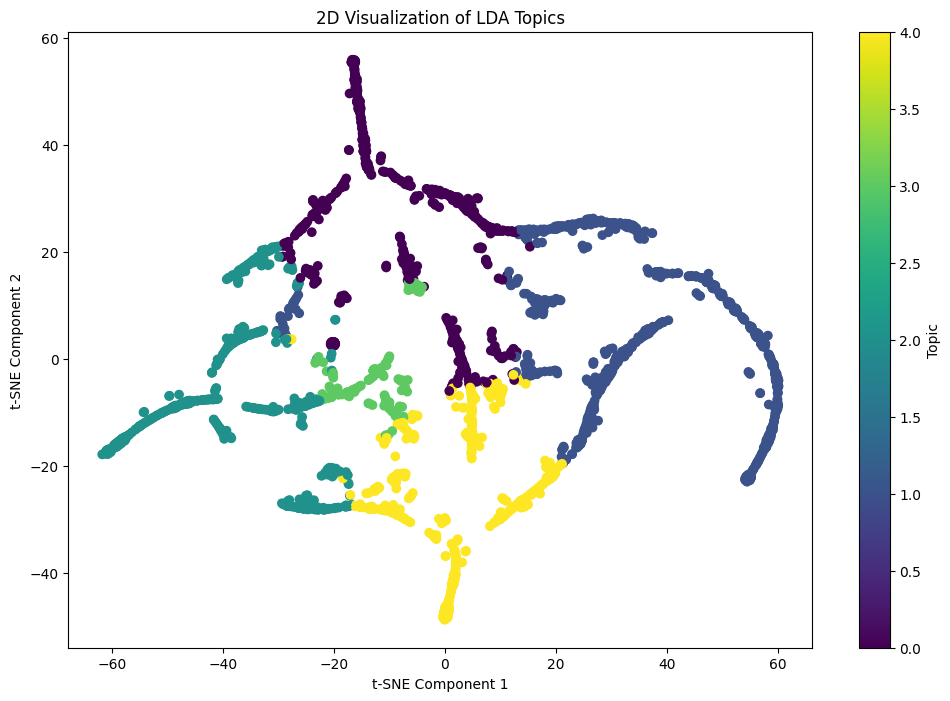

Topic #1: breast, cancer, patient, benign, imaging, mri, nipple, lesion, study, malignant
Topic #2: biopsy, breast, lesion, core, excision, needle, patient, surgical, study, diagnosis
Topic #3: breast, cancer, expression, cell, carcinoma, ductal, invasive, tissue, risk, normal
Topic #4: carcinoma, case, breast, ductal, positive, patient, invasive, er, situ, grade
Topic #5: carcinoma, ductal, lesion, situ, breast, case, cell, invasive, hyperplasia, atypical


In [ ]:
df, lda, doc_topic_dist, tsne_lda = lda_topic_analysis(articles)

In [ ]:
articles.head()

,Authors,Title,Abstract,Summary,PublicationDate,PubMedURL,Journal,LongitudinalStudy,SystematicReview,MetaAnalysis,HumanStudy,AnimalStudy,Preprocessed_Abstract,Cluster,LDA Cluster
0,"Miceli Rachel, Mercado Cecilia L, Hernandez Os...",Active Surveillance for Atypical Ductal Hyperp...,Atypical ductal hyperplasia (ADH) and ductal c...,"Furthermore, some DCIS lesions do not progress...",,https://pubmed.ncbi.nlm.nih.gov/38416903/,Journal of breast imaging,0,0,0,1,0,atypical ductal hyperplasia (adh) ductal carci...,1,1
1,"DiPrete Olivia, Wei Catherine J, Phillips Jord...",Management of Mammographic Architectural Disto...,The objective was to evaluate outcomes of mamm...,The objective was to evaluate outcomes of mamm...,,https://pubmed.ncbi.nlm.nih.gov/38416901/,Journal of breast imaging,0,0,0,0,0,objective evaluate outcome mammographic archit...,0,1
2,"Wang Xiaoxia, Du Lihong, Cao Ying, Chen Huifan...",Comparing extracellular volume fraction with a...,To investigate the feasibility of dual-energy ...,To investigate the feasibility of dual-energy ...,,https://pubmed.ncbi.nlm.nih.gov/38159522/,European journal of radiology,0,0,0,0,0,investigate feasibility dual-energy ct (dect)-...,0,0
3,"Zhang Li-Xia, Zhang Li, Jiang Li-Li, Mi Hui, L...",Perioperative care of nipple-areola complex-sp...,Breast cancer represents a prevalent malignanc...,Breast cancer represents a prevalent malignanc...,,https://pubmed.ncbi.nlm.nih.gov/38115362/,Medicine,0,0,0,0,0,breast cancer represents prevalent malignancy ...,0,2
4,"Rubio Isabel T, Wyld Lynda, Marotti Lorenza, A...","European guidelines for the diagnosis, treatme...",Breast lesions of uncertain malignant potentia...,They are challenging to categorise histologica...,,https://pubmed.ncbi.nlm.nih.gov/38061151/,European journal of surgical oncology : the jo...,1,0,0,0,0,breast lesion uncertain malignant potential (b...,0,4


In [ ]:
summarize_text(combine_abstracts(articles, 0))

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

Device set to use cpu


'Early-onset ductal carcinoma situ (dcis) is the most common form of breast cancer in postmenopausal women and is the leading cause of cancer-related deaths in this age group, according to the World Cancer Research Fund (WCRF) and the International Agency for Research on Cancer (IARC). accordingly, herein, describe rare case epc unusually elder male breast, associated ductal carcinoma situ (dcis), indepth discussion, improve understanding uncommonly provide experience treat and avoid overtreatment.'

In [ ]:
summarize_text(combine_abstracts(articles, 1))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


'Atypical ductal hyperplasia (adh) ductal carcinoma situ (dcis) relatively common breast lesion spectrum disease, atypical ductal hyperblasia nonmalignant, high-risk lesion, atypical ductal neoplasia (b3 lesion), atypical ductal lobular carcinoma situ (dcis) relatively common breast lesion, atypical ductal neoplasia (b3 lesion), atypical ductal lobular carcinoma situ (dcis) relatively common breast lesion, atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypical ductal neoplasia (b3 lesion), atypi

In [ ]:
summarize_text(combine_abstracts(articles, 2))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


'germline mutation breast cancer despite study occult atypical lesion prophylactic mastectomy specimen patient brca1/2 mutations, limited data gene associated increased breast cancer risk distribution lesion patient breast cancer, finding support benefit prophylactic mastectomy patient germline mutation patient atypical  proliferations, demonstrating demonstration ptenchemistry helpful identifying germline mutation patient atypical  proliferations, finding support prophylactic mastectomy patient germline mutation patient atypical  proliferations, demonstrating demonstration ptenchemistry helpful identifying germline mutation patient atypical  proliferations, finding support prophylactic mastectomy patient germline mutation patient atypical  proliferations, demonstrating demonstration ptenchemistry helpful identifying germline mutation patient atypical  proliferations, finding support prophylactic mastectomy patient germline mutation patient atypical  proliferations, demonstrating demon

In [ ]:
summarize_text(combine_abstracts(articles, 3))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


'ultrasound-guided vacuum-assisted excision (us-guided vae) treatment high-risk breast lesion evaluate clinical feature patient associated recurrence malignancy, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, build scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, build scoring system support decision making, develop scoring system support decision making, develop scoring system support decision making, build scoring system suppo

In [ ]:
summarize_text(combine_abstracts(articles, 4))

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


'magnetic resonance imaging (mri) is an important imaging modality for the early detection of breast cancer, but its use has been understudied and under-used in the United States and other countries, particularly among women at high risk of breast cancer, and in those undergoing invasive breast cancer surgery, such as ductal carcinoma in situ (DCIS) and ductal carcinoma in situ (DCIS), and in those undergoing invasive breast cancer surgery, such as lumpectomy and neoadjuvant treatment, and in those undergoing invasive breast cancer surgery, such as lumpectomy and neoadjuvant treatment, and in those undergoing invasive breast cancer surgery, such as lumpectomy and neoadjuvant treatment, and in those undergoing invasive breast cancer surgery, such as lumpectomy and neoadjuvant treatment, and in those undergoing invasive breast cancer surgery, such as lumpectomy and neoadjuvant treatment, and in those undergoing invasive breast cancer surgery, such as lumpectomy and neoadjuvant treatment,